In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import time
%matplotlib inline

import H_mat

# Модуль H_mat

Модуль H_mat (код в файле H_mat.py) содержит класс H_matrix для работы с Н-матрицами (блочно-скелетонным разложением матриц). В формате H_matrix реализованы сложение и умножение матриц, построение обратной матрицы и LU разложение.

Н-матрицы имеют иерархическую структуру. Матрица М разбита на четыре блока $M_{11}$, $M_{12}$, $M_{21}$, $M_{22}$ следующим образом: 

$$
|M_{11} M_{12}|
$$
$$
|M_{21} M_{22}|    
$$

Блоки $M_{ij}$, имеющие ранг r, меньший заданного r_max, хранятся в виде факторов $a \in R^{n \times r}$ и $b \in R^{r \times m}$, $M_{ij} = a b$. Блоки, не имеющие достаточно малого ранга, разбиваются на подблоки в иерархической манере, и малоранговость проверяется для подблоков. Блоки размера, меньшего 2 * r_max, хранятся в виде плотной матрицы.

## Тестовая задача

Для того, чтобы продемонстрировать работу модуля, рассмотрим тестовую одномерную задачу с логарифмическим ядром. На отрезке [0,1] равномерно расположено N зарядов с координатами $x_i$, воздействующими друг на друга с силой, пропорциональной логарифму растояния. Суммарные силы, действующие на заряды, $b_i$ известны. Необходимо найти массы зарядов $m_i$, на которые можно составить следующее уравнение:


$$
b_i = \Sigma_{j=1, j\ne i}^N m_i log(|x_i - x_j|)
$$

В матречном виде уравнение имеет вид $Am = b$, где $A_{i,j} = log(|x_i - x_j|)$ для $j \ne i$ и $A_{i,i} = 0$. Матрицы A имеет блочно-малоранговую структуру. Ее генерирует функция gen_matrix(n), описанная ниже. 

In [2]:
def kernel(x, y):
    return np.log(np.abs(x - y))

In [4]:
def gen_matrix(n):
    x = np.linspace(0,1,n)
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                A[i, j] = kernel(x[i], x[j]) 
            else:
                A[i, j] = 0
    return A

Сгенерируем и визуализируем матрицу A для N = 500. 

In [5]:
A = gen_matrix(500)  

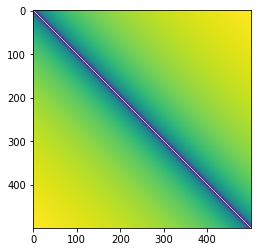

In [7]:
plt.imshow(A)

Наибольшие по модулю элементы сосредоточены вблизи диагонали, но на диагонали - нули. Эта матрица имеет Н-структуру. 

Функция H_mat.create(A, tol, rang) строит Н-матрицу по плотной матрице A. Проверка на малоранговость и разложение на факторы выполняются при помощи SVD. Зная ядро и сетку можно построить H-матрицу без построения плотной матрицы A, но в данном коде такая возможность не риализована. 

Параметры: ранг блока считается малым, если блок имеет не более 'rang' сингулярных чисел, превышающих 'tol'.

In [8]:
H = H_mat.create(A, 1e-6, 10)

Функция H.show() позволяет визуализировать блочную структуру матрицы H

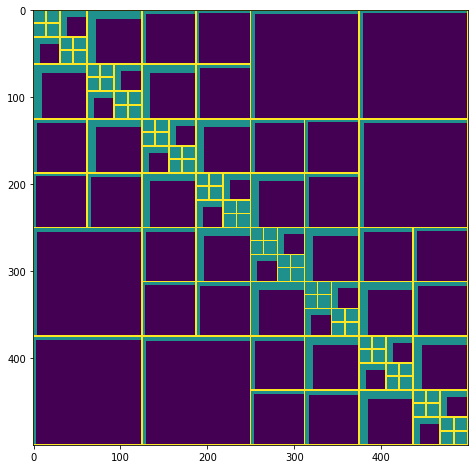

In [9]:
plt.figure(figsize=(8,8))
plt.imshow(H.show())

Желтым обозначены границы блоков. Полностью зеленые блоки имеют плотную структуру. Другие блоки имеют малый ранг, причем ширина зеленой линии соответствует рангу матрицы. Плотные блоки сосредоточены на диагонали. Чем дальше от диагонали, тем ранг блогов ниже, что соответствует тому, что удаленные от диагонали блоки описывают взаимодействие далеко разнесенных групп точек.

## Сложение

Для того, чтобы показать, что сложение работает, сложем матрицу Н с самой собой.

In [10]:
H_sum = H + H

функция H_sum.mat() возвращает плотную матрицу. H_sum.mat() должны быть равна H.mat() + H.mat(). Для того, чтобы проверить это равенство, используем функцию np.linalg.norm, вычисляющую вторую норму. Относительная погрешность при сложении H-матриц имеет порядок 1e-16.

In [11]:
np.linalg.norm(H_sum.mat() - H.mat() - H.mat()) / np.linalg.norm(H_sum.mat())

2.771195375023886e-16

Матрица Н_sum имеет такую же блочную структуру, как и матрица Н, что видно на следующем графике

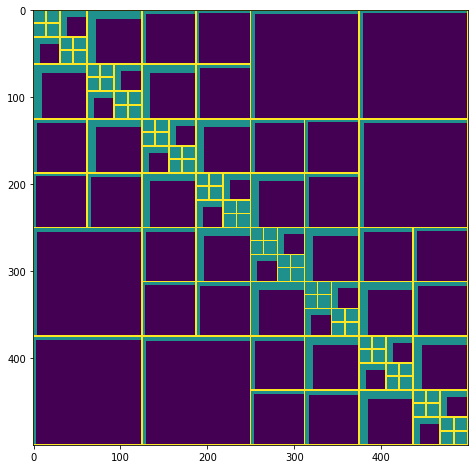

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(H_sum.show())

## Умножение

Для того, чтобы показать, что умножение работает, посчитаем матрицу H_mul = H * H

In [13]:
H_mul = H @ H

Относительная ошибка умножения, вычисленая ниже, и имеет порядок 1e-15

In [14]:
np.linalg.norm(H_mul.mat() - H.mat() @ H.mat()) / np.linalg.norm(H_mul.mat())

4.18459658695082e-15

Блочная структура матрицы H_mul приведена ниже. Она имеет такую же блочную структуру, как и матрица Н.

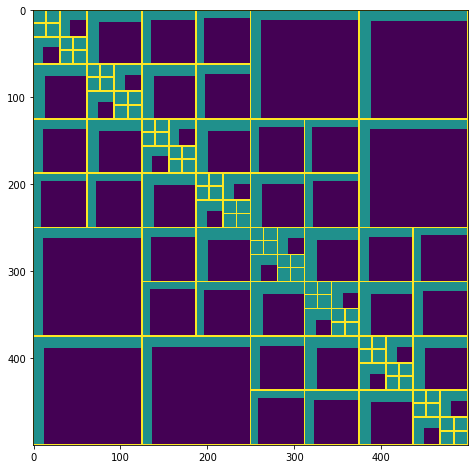

In [15]:
plt.figure(figsize=(8,8))
plt.imshow(H_mul.show())

## Обращение матриц

Вычислим матрицу H_inv, обратную к матрице H

In [16]:
H_inv = H.inv()

Относительная погрешность вычисления обратной матрицы имеет порядок 1e-10. Для обращения плотной матрицы использована функция np.linalg.inv()

In [17]:
np.linalg.norm(np.linalg.inv(H.mat()) - H_inv.mat()) / np.linalg.norm(H.mat())

2.9021630494523856e-10

Обратная матрица имеет ту же блочную структуру, что и матрица H.

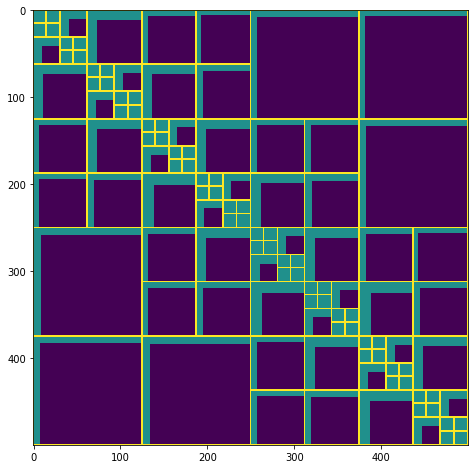

In [18]:
plt.figure(figsize=(8,8))
plt.imshow(H_inv.show())

Зная обратную матрицу решим систему Hx = b. Случайный вектор b сгенерируем функцией np.rand.random(N)

In [19]:
b = np.random.rand(500)

Решим систему

In [20]:
x = H_inv @ b

Равенство Hx = b выполняется с относительной погрешностью 1e-8

In [21]:
np.linalg.norm(H.mat() @ x - b) / np.linalg.norm(b)

1.91634334691343e-08

## LU факторизация

Проверим работоспособность LU факторизации, которую строит функция H.lu()

In [22]:
L, U = H.lu()

Ниже изображена блочная структура факторов L и U. Это нижняя и верхняя треугольные матрицы, имеющие такую же блочную структуру, как матрица H.

Text(0.5, 1.0, 'U factor')

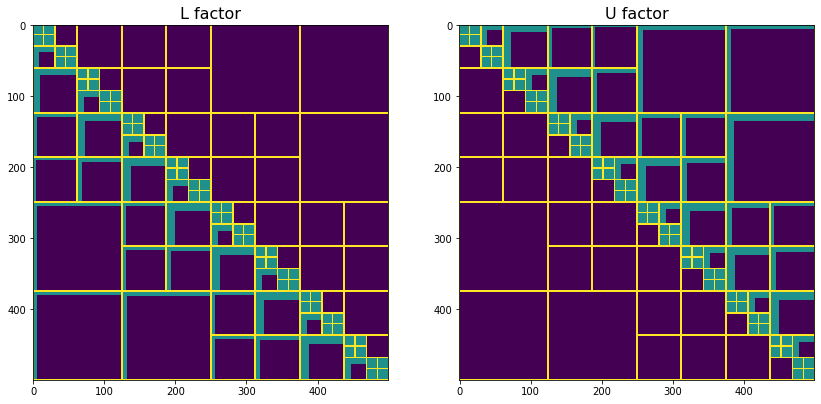

In [23]:
plt.figure(figsize=(14,14))
plt.subplot(1,2,1)
plt.imshow(L.show())
plt.title('L factor', fontsize=16)

plt.subplot(1,2,2)
plt.imshow(U.show())
plt.title('U factor', fontsize=16)

Равенство LU = H выполняется с относительной точностью 1e-9.

In [24]:
np.abs(L.mat() @ U.mat() - H.mat()).max()

5.398435920511702e-09

Зная L и U, найдем решение системы Hx = b, используя функцию H_mat.lu_solve(L, U, b)

In [25]:
x = H_mat.lu_solve(L, U, b)

Вектор x удовлетворяет уравнению Hx = b с относительной погрешностью 1e-8

In [26]:
np.linalg.norm(H.mat() @ x - b)

8.731768682066715e-09

# Асимптотическая сложность реализованных методов (new)

Ниже приведены результаты расчетов, позволяющих оценить сложность реализованных для Н-матриц алгоритмов. Сравнение выполняется с алгоритмами для работы с плотными матрицами, реализованными в модуле numpy (Lapack). Во всех рассмотренных примерах алгоритмы для работы с плотными матрицами требуют меньше времени, чем реализованные мной алгоритмы для работы с Н-матрицами. При этом можно ожидать, что при достаточно больших n алгоритм в Н-формате оказаться эффективнее, так как они имеют лучшее асимптотическое поведение. 

Отмечу, что умножение матрицы на вектор в Н-формате требует меньше времени, чем умножения плотной матрицы на вектор, уже при n = 1000. Это важно при реализации итерационных методов и подробнее описано в файле, посвященном итерационному решению систем с Н-матрицами.

Для того, чтобы оценить сложность реализованных методов, построим серию матриц со значением n = [100, 200, 400, 800, 1600, 3200]. Плотные матрицы хранятся в списке dens_mat, H_матрицы - в списке h_mat.

In [27]:
ns = [100, 200, 400, 800, 1600, 3200]
h_mat = []
dens_mat = []

for n in ns:
    A = gen_matrix(n)
    dens_mat.append(A)
    H = H_mat.create(A, 1e-6, 10)
    h_mat.append(H)

## Память

Оценим необходимую для хранения Н-матрицы память. Функция H.mem() возвращает число переменных типа double, хранящихся на нижних уровнях матрицы. Функция A.size() возвращает число переменных типа double, необходимых для хранения плотной матрицы.

In [29]:
h_mem = []
for H in h_mat:
    h_mem.append(H.mem())

In [30]:
dens_mem = []
for A in dens_mat:
    dens_mem.append(A.size)

Как можно видеть на графике ниже, объем памяти, необходимый для хранения Н-матрицы, (голубая линия) растет с ростом n немного быстрее, чем линейно (линейная зависимость - сплощная черная линия). Объем памяти, необходимый для хранения плотной матрицы, (оранжевая линия) растет с ростом n квадратично (квадратичная зависимость - прерывистая черная линия). При всех n для хранения Н-матрицы нужно меньше памяти, чем для хранения плотной матрицы.

Text(0, 0.5, 'storage size')

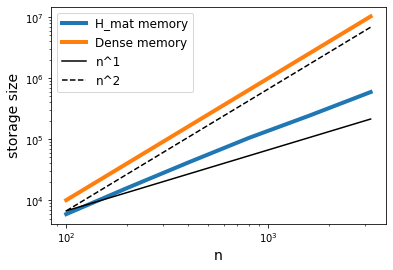

In [65]:
plt.loglog(ns, h_mem, label="H_mat memory", lw=4)
plt.loglog(ns, dens_mem, label="Dense memory", lw=4)
plt.plot(ns, [n/1.5e-2 for n in ns], 'k-', label="n^1")
plt.plot(ns, [n**2/1.5e0 for n in ns], 'k--',label="n^2")
plt.legend(fontsize=12)
plt.xlabel("n", fontsize=14)
plt.ylabel('storage size', fontsize=14)

## Сложность сложения

In [37]:
h_sum_time = []
for h in h_mat:    
    m = 10
    time1 = time.process_time()
    for i in range(m):
        h_sum = h + h
    time2 = time.process_time()
    
    dtime = (time2 - time1) / m
    h_sum_time.append(dtime)

In [38]:
dens_sum_time = []
for A in dens_mat:    
    m = 100
    time1 = time.process_time()
    for i in range(m):
        A_sum = A + A
    time2 = time.process_time()
    
    dtime = (time2 - time1) / m
    dens_sum_time.append(dtime)

На графике ниже приведено время, необходимое для выполнения сложения. Сложение в Н-формате имеет линейную сложность (синяя линия). Сложение плотных матриц имеет квадратичную сложность (оранжевая линия). При рассмотренных n сложение плотных матриц требует значительно меньше времени, но при достаточно больших n сложение в Н-формате должно стать быстрее.

Text(0, 0.5, 'time (sec)')

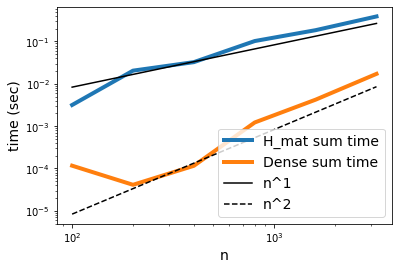

In [66]:
plt.loglog(ns, h_sum_time, label="H_mat sum time", lw=4)
plt.loglog(ns, dens_sum_time, label="Dense sum time", lw=4)
plt.plot(ns, [n/1.2e4 for n in ns], 'k-', label="n^1")
plt.plot(ns, [n**2/1.2e9 for n in ns], 'k--',label="n^2")
plt.legend(fontsize=14)
plt.xlabel("n", fontsize=14)
plt.ylabel("time (sec)", fontsize=14)

## Сложность умножение

In [50]:
h_mul_time = []
for H in h_mat:
    m = 1
    time1 = time.process_time()
    for i in range(m):
        H_mul = H @ H
    time2 = time.process_time()
    
    dtime = (time2 - time1) / m
    h_mul_time.append(dtime)

In [55]:
dens_mul_time = []
for A in dens_mat:
    m = 10
    time1 = time.process_time()
    for i in range(m):
        A_mul = A @ A
    time2 = time.process_time()
    
    dtime = (time2 - time1) / m
    dens_mul_time.append(dtime)

На графике ниже приведено время умножения матриц. В Н-формате сложность умножения немного выше, чем квадратичная. Сложность умножения плотных матриц кубическая. При рассмотренных n умножение плотных матриц выполняется значительно быстрее, чем умножение в Н-формате, но при достаточно больших n умножение в Н-формате должно стать быстрее.

Text(0, 0.5, 'time (sec)')

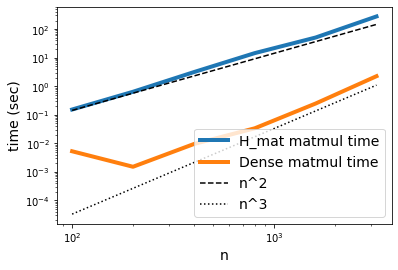

In [68]:
plt.loglog(ns, h_mul_time, label="H_mat matmul time", lw=4)
plt.loglog(ns, dens_mul_time, label="Dense matmul time", lw=4)
plt.plot(ns, [n**2/0.7e5 for n in ns], 'k--',label="n^2")
plt.plot(ns, [n**3/3e10 for n in ns], 'k:',label="n^3")
plt.legend(fontsize=14)
plt.xlabel("n", fontsize=14)
plt.ylabel("time (sec)", fontsize=14)

## Сложность обращения

In [62]:
h_inv_time = []
for H in h_mat:
    m = 1
    time1 = time.process_time()
    for i in range(m):
        H_inv = H.inv()
    time2 = time.process_time()
    
    dtime = (time2 - time1) / m
    h_inv_time.append(dtime)

In [70]:
dens_inv_time = []
for A in dens_mat:
    m = 10
    time1 = time.process_time()
    for i in range(m):
        A_inv = np.linalg.inv(A)
    time2 = time.process_time()
    
    dtime = (time2 - time1) / m
    dens_inv_time.append(dtime)

В Н-формате сложность обращения оказывается выше квадратичной, но ниже кубической. Сложность обращения плотных матриц кубическая. Обращение плотных матриц требует меньше времени, чем обращение Н-матрицы при всех рассмотренных n.

Text(0, 0.5, 'time (sec)')

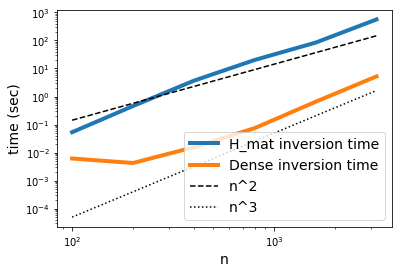

In [104]:
plt.loglog(ns, h_inv_time, label="H_mat inversion time", lw=4)
plt.loglog(ns, dens_inv_time, label="Dense inversion time", lw=4)
plt.plot(ns, [n**2/0.7e5 for n in ns], 'k--',label="n^2")
plt.plot(ns, [n**3/2e10 for n in ns], 'k:',label="n^3")
plt.legend(fontsize=14)
plt.xlabel("n", fontsize=14)
plt.ylabel("time (sec)", fontsize=14)

## LU факторизация

In [82]:
luf_time = []
lus_time = []
for n, h1 in zip(ns, h_mat):
    
    time1 = time.process_time()
    L, U = h1.lu()
    time2 = time.process_time()
    
    dtime = (time2 - time1)
    luf_time.append(dtime)
    
    b = np.random.rand(n)
    time1 = time.process_time()
    x = H_mat.lu_solve(L, U, b)
    time2 = time.process_time()
    
    dtime = (time2 - time1)
    lus_time.append(dtime)

In [84]:
d_luf_time = []
d_lus_time = []
for n, A in zip(ns, dens_mat):
    m = 10
    
    time1 = time.process_time()
    for i in range(m):
        lu = H_mat.scipy.linalg.lu_factor(A)
    time2 = time.process_time()
    
    dtime = (time2 - time1) / m
    d_luf_time.append(dtime)
    
    b = np.random.rand(n)
    time1 = time.process_time()
    for i in range(m):
        x = H_mat.scipy.linalg.lu_solve(lu, b)
    time2 = time.process_time()
    
    dtime = (time2 - time1) / m
    d_lus_time.append(dtime)

На левом графике приведено время факторизации, на правом - время решения факторизованной системы. Сложность факторизации в Н-формате близка к квадратичной. Сложность факторизации плотной матрицы кубическая. Сложность решения факторизованной системы в Н-формате близка к линейной. Сложность решения системы с плотными факторами близка к квадратичной. При всех рассмотренных n операции с плотными матрицами требуют меньше времени, чем операции в Н-формате, но при достаточно больших n ситуация может ихзмениться на обратную, так как асимптотическая сложность алгоритмов в Н-формате оказывается ниже.

Text(0, 0.5, 'time (sec)')

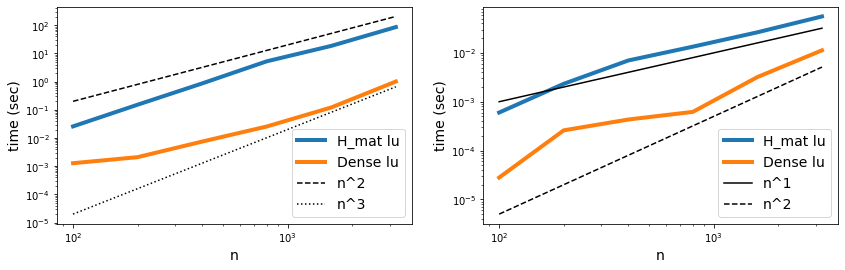

In [103]:
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
plt.loglog(ns, luf_time, label="H_mat lu", lw=4)
plt.loglog(ns, d_luf_time, label="Dense lu", lw=4)
plt.plot(ns, [n**2/0.5e5 for n in ns], 'k--',label="n^2")
plt.plot(ns, [n**3/5e10 for n in ns], 'k:',label="n^3")
plt.legend(fontsize=14)
plt.xlabel("n", fontsize=14)
plt.ylabel("time (sec)", fontsize=14)


plt.subplot(1,2,2)
plt.loglog(ns, lus_time, label="H_mat lu", lw=4)
plt.loglog(ns, d_lus_time, label="Dense lu", lw=4)
plt.plot(ns, [n/1e5 for n in ns], 'k-', label="n^1")
plt.plot(ns, [n**2/2e9 for n in ns], 'k--',label="n^2")
plt.legend(fontsize=14)
plt.xlabel("n", fontsize=14)
plt.ylabel("time (sec)", fontsize=14)

## Заключение

На Python + numpy реализован наивный алгоритм для работы с Н-матрицами. Показано, что в Н-формате алгебраические операции, обращение и LU-факторизация матриц работает корректно. Показано, что сложение требует примерно O(n) времени; умножение, обращение и факторизация - O(n^2).

Можно переписать код на C++. Не уверен, что это позволит сильно ускорить код, так как основное время вычисления занимают операции с плотными матрицами, для выполнения которых numpy обращается к Lapack.